In [1]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'

In [3]:
adata = sc.read_h5ad(path + 'data/merged_dengue_and_covid_all.h5ad')
adata.obs.Dataset.cat.categories

Index(['Adults_citeseq', 'Adults_viscRNAseq', 'Arunachalam2020',
       'Children_viscRNAseq', 'Meyer_nikolic'],
      dtype='object')

In [7]:
adata

AnnData object with n_obs × n_vars = 966804 × 42244
    obs: 'Age', 'Condition', 'DENV_minus', 'DENV_plus', 'DENV_reads', 'Gender', 'ID', 'batch', 'cell_quality', 'cell_subtype', 'cell_subtype_2', 'cell_subtype_zhiyuan', 'cell_type', 'cell_type_zhiyuan', 'cell_type_new_2', 'doublets', 'mt_frac', 'n_counts', 'n_genes', 'platform', 'viral_load_nano', 'viral_load_qpcr', 'Dengue_exposure', 'cell_subtype_luca', 'cell_subtype_new', 'cell_type_luca', 'cell_type_new', 'cell_subtype_NK', 'Dataset', 'Admission', 'Sample', 'Stage', 'Experiment', 'Date', 'Date of symptoms onset', 'Days', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'mad_prd', 'n_proteins_by_counts', 'total_counts_adt', 'total_counts_log1p', 'total_counts_adt_log1p', 'rna_quality', 'protein_quality', 'high_quality', 'TCR_umi', 'TCR_umi_log1p', 'TCR_IR_VJ_2_c_call', 'TCR_IR_VDJ_2_c_call', 'TCR_IR_VJ_2_d_call', 'TCR_IR_VDJ_2_d_call', 'TCR_IR_VJ_2_v_call', 'TCR_IR_VDJ_

In [6]:
df = adata.obs.groupby(['Dataset', 'ID']).size()
df[df!=0]

Dataset         ID      
Adults_citeseq  1-056-01     8171
                1-056-02    10171
                1-172-01     4265
                1-172-02    18239
                1_001_1     11002
                            ...  
Meyer_nikolic   PP11           72
                PP13         6282
                PP14         2512
                PP15         9016
                PP16         2919
Length: 154, dtype: int64

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata, base=2)
adata.var_names_make_unique()


In [13]:
filtered = adata[(adata.obs.Dataset.isin(['Children_viscRNAseq', 'Adults_citeseq'])) & 
                 (adata.obs.cell_quality == 'high') &
                (~adata.obs.ID.isin(['1_052_02', '1_052_01', '1_057_02', '1_057_01',])) &
                (~adata.obs.Condition.isin(['co', 'DWS']))]

filtered = filtered[:, [x for x in filtered.var_names if not x.startswith('Isotype')]]
sc.pp.filter_genes(filtered, min_cells=3)
filtered.obs.rna_ct_2_2.cat.reorder_categories(['NK cells', 'Monocytes', 'cDCs', 'pDCs', 'T cells', 'B cells', 'Plasmablasts', 'Platelets', 'HSPCs', 'Erythroblasts', 'Doublets', ], inplace=True)
filtered

AnnData object with n_obs × n_vars = 275980 × 30598
    obs: 'Age', 'Condition', 'DENV_minus', 'DENV_plus', 'DENV_reads', 'Gender', 'ID', 'batch', 'cell_quality', 'cell_subtype', 'cell_subtype_2', 'cell_subtype_zhiyuan', 'cell_type', 'cell_type_zhiyuan', 'cell_type_new_2', 'doublets', 'mt_frac', 'n_counts', 'n_genes', 'platform', 'viral_load_nano', 'viral_load_qpcr', 'Dengue_exposure', 'cell_subtype_luca', 'cell_subtype_new', 'cell_type_luca', 'cell_type_new', 'cell_subtype_NK', 'Dataset', 'Admission', 'Sample', 'Stage', 'Experiment', 'Date', 'Date of symptoms onset', 'Days', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'mad_prd', 'n_proteins_by_counts', 'total_counts_adt', 'total_counts_log1p', 'total_counts_adt_log1p', 'rna_quality', 'protein_quality', 'high_quality', 'TCR_umi', 'TCR_umi_log1p', 'TCR_IR_VJ_2_c_call', 'TCR_IR_VDJ_2_c_call', 'TCR_IR_VJ_2_d_call', 'TCR_IR_VDJ_2_d_call', 'TCR_IR_VJ_2_v_call', 'TCR_IR_VDJ_

In [14]:
adata2 = adata[(adata.obs.Dataset.isin(['Arunachalam2020'])) & 
     (adata.obs.Condition == 'Healthy')]
adata2 = adata2[:, adata2.var.feature_types == 'Gene Expression']
sc.pp.filter_genes(adata2, min_cells=3)


In [18]:
varnames = [x for x in adata2.var_names if x in filtered.var_names]

In [19]:
ct_map = {'Monocytes': ['classical monocytes', 'non-classical monocytes', 'intermediate monocytes'],
      'cDCs': ['cDC1', 'cDC2', 'cDC4', 'asDCs'],
      'NK cells': ['signaling NK cells', 'adaptive NK cells', 'cytotoxic NK cells']}
list(ct_map.keys())

['Monocytes', 'cDCs', 'NK cells']

In [20]:
cts = list(ct_map.keys())

df_new = pd.DataFrame([])
for ct, cts in ct_map.items():
    #ct = 'NK cells'
    NK = filtered[filtered.obs.rna_ct_2_2 == ct]
    #sc.pp.filter_genes(NK, min_cells=3)
    df = sc.get.obs_df(NK, keys=[*varnames, 'ID', 'Condition', 'Sample', 'Days']).groupby(['Condition', 'Sample', 'ID', 'Days']).mean().dropna()
    df = df.reset_index()
    days_map = {2:.5+2/21, 3:.5+3/21, 4:.5+4/21, 5:.5+5/21, 6:.5+6/21, 7:.5+7/21, 8:.5+8/21, 10:.5+10/21, 11:.5+11/21, 
            22:1.5+1/69, 32:1.5+11/69, 33:1.5+12/69, 41:1.5+20/69, 42:1.5+21/69, 69:1.5+48/69, 
            257:2.5+167/275 }
    df['Days_scaled'] = df.Days.map(days_map)
    df['Dengue_exposure'] = [NK[NK.obs.Sample == x].obs.Dengue_exposure.unique().to_list()[0] for x in df.Sample]

    NK2 = adata2[adata2.obs.rna_ct_3.isin(ct_map[ct])].copy()
    #sc.pp.filter_genes(NK2, min_cells=3)
    df2 = sc.get.obs_df(NK2, keys=[*varnames, 'ID']).groupby(['ID']).mean().dropna()
    df2['Condition'] = 'H'
    df2['Sample'] = 'Healthy'
    df2['Days'] = -1
    df2['Days_scaled'] = 0
    df2['Dengue_exposure'] = 'Healthy'
    df2 = df2.reset_index()[df.columns]

    
    df_all = pd.concat([df, df2])
    df_all['Stage'] = 0.5
    df_all.loc[(df_all.Days>0), 'Stage'] = 1
    df_all.loc[(df_all.Days>21), 'Stage'] = 2
    df_all.loc[(df_all.Days>90), 'Stage'] = 3
    
    df_all['cell_type'] = ct
    
    df_new = pd.concat([df_new, df_all])
#df_new



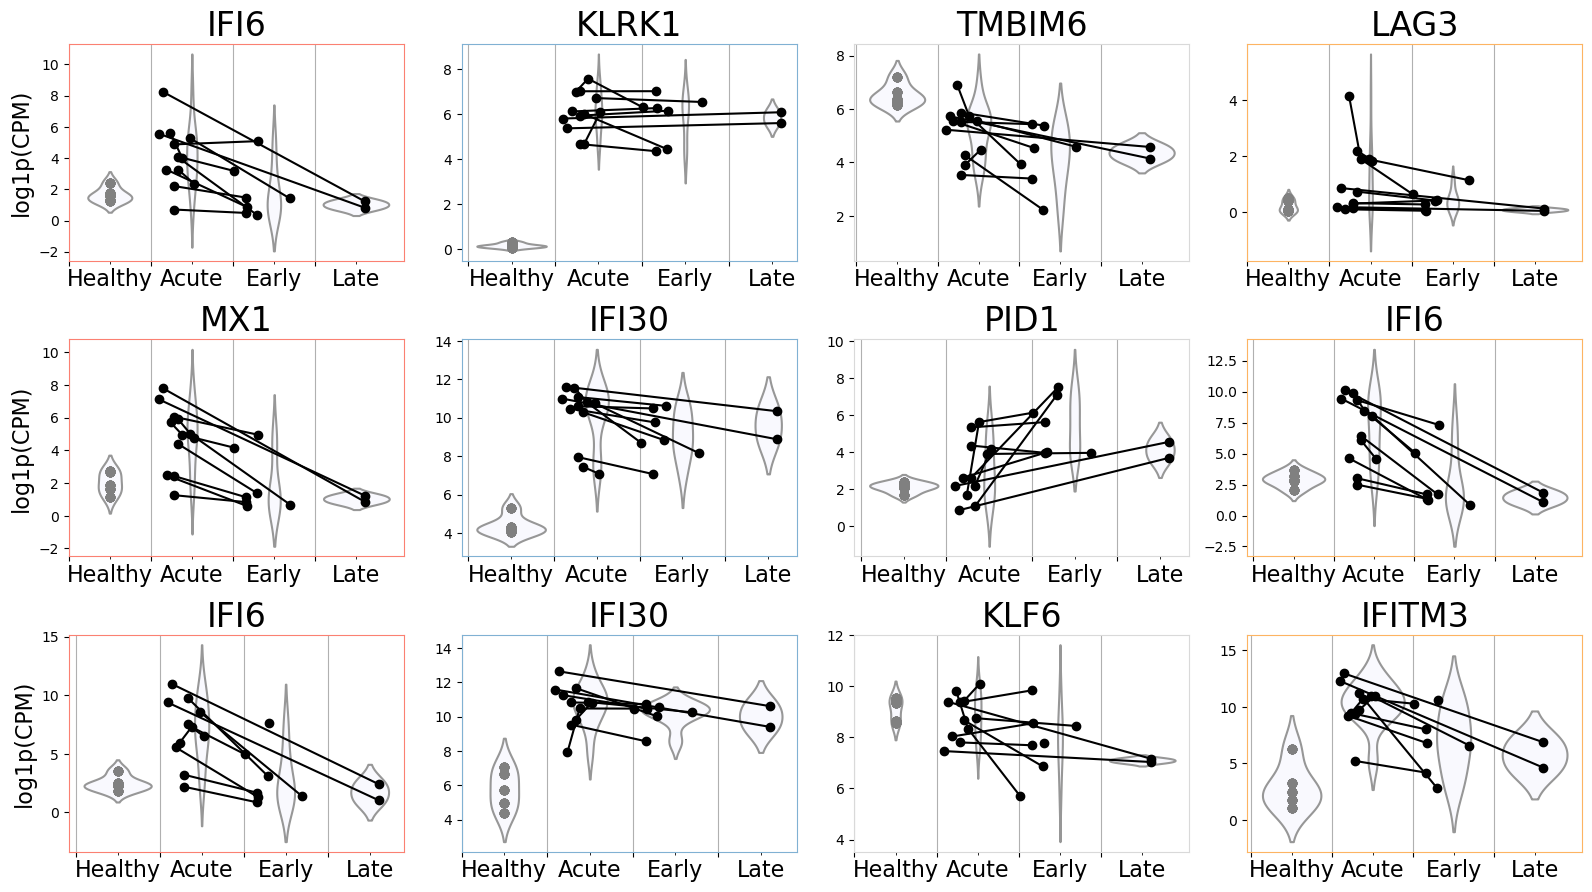

In [22]:
cts = ['NK cells', 'Monocytes', 'cDCs']
genes_ct = {'NK cells': ['IFI6', 'KLRK1', 'TMBIM6', 'LAG3', ],
           'Monocytes': ['MX1', 'IFI30', 'PID1', 'IFI6'],
           'cDCs': ['IFI6', 'IFI30', 'KLF6', 'IFITM3']}
n_genes = 4
fig, axs = plt.subplots(len(cts), n_genes, figsize=(n_genes*4, len(cts)*3))

for axsrow, ct in zip(axs, cts):
    colors = ['tomato', 'steelblue']
    colors = []
    #for i in [8, 3, 4, 5]: colors.append(sns.color_palette('Set3')[i])
    for i in [5, 8, 4, 3]: colors.append(sns.color_palette('Set3')[i])


    genes_ct_i = genes_ct[ct]
    
    df_ct = df_new[df_new.cell_type==ct].copy()
    df = df_ct[df_ct.Condition!='H'].copy()
    df_test = df_ct[df_ct.Condition=='H'].copy()

    for i, (ax, gene) in enumerate(zip(axsrow, genes_ct_i)):
        color = colors.pop()
        sns.violinplot(df_ct["Stage"], y=df_ct[gene], native_scale=True,
                       density_norm="width", inner=None, color='ghostwhite', ax=ax)
        
        df_i = df[['Condition', 'Dengue_exposure', 'Sample', 'ID', 'Days_scaled', 'Stage', gene]]
        for s in df_i.Sample.unique():
            df_s = df_i[df_i.Sample == s]
            if df_s['Dengue_exposure'].unique()[-1] == 'Primary': marker='s'
            ax.plot('Days_scaled', gene, data=df_s, linestyle='-', 
                color = 'black', marker='o', )
            ax.plot('Days_scaled', gene, data=df_test, linestyle='None', 
                color = 'gray', marker='o', )
                    
        ax.set_xticks([-0.5, 0.5, 1.5, 2.5, ], )
        ax.set_xticks([0, 1., 2., 3.,], minor=True, 
                      labels = ['Healthy', 'Acute', 'Early', 'Late'], fontsize=16)
        ax.grid(axis='x', which='major')
        ax.set_title(gene, fontsize=24)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
        
        
    axsrow[0].set_ylabel(f'log1p(CPM)', fontsize=16)


fig.tight_layout(pad=1.0)
#fig.text(-0.02, 0.52, title, va='center', fontsize=18, rotation=90)
#fig.text(0.52, -0.02, 'Days', va='center', fontsize=18, rotation=0)
#fig.savefig(f'{save_figures}{title}_connected_plot.svg')
plt.show()